[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)



# 映射-归约（Map-reduce）

## 评论（Review）

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

我们正在构建一个多功能的研究助手，它将本课程中的所有模块串联起来。

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.
We just covered parallelization and sub-graphs.

我们刚刚介绍了并行化和子图。

## 目标（Goals）

Now, we're going to cover [map reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/).

现在，我们将要讲解 [map reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/)。



In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

我们将使用 [LangSmith](https://docs.smith.langchain.com/) 用于 [tracing](https://docs.smith.langchain.com/concepts/tracing)。



In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## 问题（Problem）

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

映射-归约操作对于高效的任务分解和并行处理至关重要。

It has two phases:

它有两个阶段：

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

`Map` - 将任务分解为更小的子任务，并行处理每个子任务。

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

(2) `Reduce` - 汇总所有已完成的并行子任务的结果。

Let's design a system that will do two things:

让我们设计一个系统，该系统将完成两件事情：

(1) `Map` - Create a set of jokes about a topic.
(2) `Reduce` - Pick the best joke from the list.

(2) `Reduce` - 从列表中挑选最好的笑话。

We'll use an LLM to do the job generation and selection.

我们将使用 LLM 来进行任务生成和选择。



In [29]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """生成一个包含3个子主题的列表，这些子主题都与以下总体主题相关：{topic}。返回一个JSON对象，其中包含一个'subjects'键，其值为字符串列表。"""
joke_prompt = """生成一个关于{subject}的笑话。返回一个JSON对象，其中包含一个'joke'键，其值为字符串。"""
best_joke_prompt = """以下是关于 {topic} 的一组笑话。请选出最棒的一个！返回最佳笑话的 ID，第一个笑话的 ID 为 0。响应必须是一个 JSON 对象，且仅包含一个键 'id'，其值为整数 ID。笑话：\n\n  {jokes}"""
# LLM
model = ChatOpenAI(
    model="qwen-plus-2025-04-28",
    api_key="sk-ba2dda3817f145d7af141fdf32e31d90",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)

## 状态（State）

### 并行化笑话生成（Parallelizing joke generation）

First, let's define the entry point of the graph that will:

首先，让我们定义图的入口点，它将：

* Take a user input topic
* Produce a list of joke topics from it
* Send each joke topic to our above joke generation node

*接收用户输入的主题* 从该主题生成一系列笑话主题  
* 将每个笑话主题发送到我们上述的笑话生成节点

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation

我们的状态有一个 `jokes` 键，它将累积来自并行化笑话生成的笑话。



In [9]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    """定义一个Pydantic模型，用于表示主题列表。"""
    subjects: list[str] # 主题字符串列表

class BestJoke(BaseModel):
    """定义一个Pydantic模型，用于表示最佳笑话的ID。"""
    id: int # 最佳笑话的索引ID
    
class OverallState(TypedDict):
    """定义整个图的总体状态，使用TypedDict以便于类型提示和状态管理。"""
    topic: str # 当前讨论的主题
    subjects: list # 生成的子主题列表
    jokes: Annotated[list, operator.add] # 笑话列表，使用operator.add表示列表内容会累加而不是覆盖
    best_selected_joke: str # 最终选出的最佳笑话

Generate subjects for jokes.

生成笑话的主题。



In [10]:
#用于生成主题
def generate_topics(state: OverallState):
    #使用 Python 的 format() 方法来构建一个提示字符串（ prompt ）
    prompt = subjects_prompt.format(topic=state["topic"])
    #.with_structured_output(Subjects) 它指示模型尝试将其输出格式化为 Subjects 类
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

In [10]:
prompt = subjects_prompt.format(topic="ai")
print(prompt)

生成一个包含3个子主题的列表，这些子主题都与以下总体主题相关：ai。


In [11]:
print(model.with_structured_output(Subjects))

first=RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7f38c3677490>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7f38c30eac90>, root_client=<openai.OpenAI object at 0x7f38c3811790>, root_async_client=<openai.AsyncOpenAI object at 0x7f38c30ea890>, model_name='qwen-plus-2025-04-28', model_kwargs={}, openai_api_key=SecretStr('**********'), openai_api_base='https://dashscope.aliyuncs.com/compatible-mode/v1'), kwargs={'response_format': <class '__main__.Subjects'>, 'ls_structured_output_format': {'kwargs': {'method': 'json_schema', 'strict': None}, 'schema': {'type': 'function', 'function': {'name': 'Subjects', 'description': '定义一个Pydantic模型，用于表示主题列表。', 'parameters': {'properties': {'subjects': {'items': {'type': 'string'}, 'type': 'array'}}, 'required': ['subjects'], 'type': 'object'}}}}}, config={}, config_factories=[]) middle=[] last=RunnableBinding(bound=RunnableLambda(...), kwarg

In [7]:
subjects_prompt ="""生成3个与主题{topic}相关的子主题。返回一个JSON对象，其中包含一个'subjects'键，其值为字符串列表。"""
#使用 Python 的 format() 方法来构建一个提示字符串（ prompt ）
prompt = subjects_prompt.format(topic="ai")
#.with_structured_output(Subjects) 它指示模型尝试将其输出格式化为 Subjects 类
response = model.with_structured_output(Subjects).invoke(prompt)

In [13]:
response

Subjects(subjects=['人工智能伦理', '机器学习算法', '自然语言处理'])

Here is the magic: we use the [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) to create a joke for each subject.

这就是关键所在：我们使用 [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) 为每个主题创建一个笑话。

This is very useful! It can automatically parallelize joke generation for any number of subjects.

这非常有用！它可以自动为任意数量的主题并行生成笑话。

* `generate_joke`: the name of the node in the graph
* `{"subject": s`}: the state to send

*`generate_joke`: 图中节点的名称* `{"subject": s`}: 要发送的状态

`Send` allow you to pass any state that you want to `generate_joke`! It does not have to align with `OverallState`.

`Send` 允许您传递任何想要的状态给 `generate_joke`！它不需要与 `OverallState` 保持一致。

In this case, `generate_joke` is using its own internal state, and we can populate this via `Send`.

在这种情况下，`generate_joke` 使用其自身的内部状态，我们可以通过 `Send` 来填充它。



In [11]:
from langgraph.types import Send
def continue_to_jokes(state: OverallState):
    # 该函数根据当前状态中的主题列表，为每个主题生成一个 Send 对象。
    # 每个 Send 对象都指示图将数据发送到名为 "generate_joke" 的节点，
    # 并将当前主题作为 "subject" 参数传递，从而实现并行生成笑话。
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

### 笑话生成（映射）（Joke generation (map)）

Now, we just define a node that will create our jokes, `generate_joke`!

现在，我们只需定义一个节点来创建我们的笑话，`generate_joke`！

We write them back out to `jokes` in `OverallState`! 

我们将它们写回到 `jokes` 在 `OverallState`！

This key has a reducer that will combine lists.

这个键有一个 reducer，它将合并列表。



In [12]:
# 定义 JokeState，用于表示生成笑话任务的输入状态。
class JokeState(TypedDict):
    subject: str#笑话的主题

# 定义 Joke 模型，用于表示模型生成的笑话的结构。
class Joke(BaseModel):
    joke: str#笑话的文本内容

# 定义生成笑话的函数。
def generate_joke(state: JokeState):
    # 根据 joke_prompt 模板和当前状态中的主题格式化提示。
    prompt = joke_prompt.format(subject=state["subject"])
    # 调用语言模型，并指定输出应结构化为 Joke 类型。
    response = model.with_structured_output(Joke).invoke(prompt)
    # 返回一个包含生成的笑话的字典，键为 "jokes"。
    return {"jokes": [response.joke]}

### 最佳笑话选择（减少）（Best joke selection (reduce)）

Now, we add logic to pick the best joke.

现在，我们添加逻辑来挑选最好的笑话。



In [13]:
def best_joke(state: OverallState):
    # 将状态中所有笑话列表连接成一个字符串，每个笑话之间用两个换行符分隔
    jokes = "\n\n".join(state["jokes"])
    # 使用主题和所有笑话格式化最佳笑话提示语
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    # 调用模型，期望其输出符合 BestJoke 结构（包含最佳笑话的ID）
    response = model.with_structured_output(BestJoke).invoke(prompt)
    # 根据模型返回的ID，从笑话列表中选择最佳笑话，并将其存储在状态的 best_selected_joke 字段中
    return {"best_selected_joke": state["jokes"][response.id]}

## 编译（Compile）



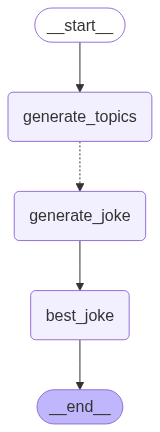

In [30]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# 构建图：将所有组件组合在一起构建我们的流程图
graph = StateGraph(OverallState)

graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)

graph.add_edge(START, "generate_topics")
# 根据条件决定是否继续生成笑话
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
# 生成笑话后执行选择最佳笑话
graph.add_edge("generate_joke", "best_joke")
# 选择最佳笑话后流程结束
graph.add_edge("best_joke", END)


app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [31]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "日本广岛原子弹"}):
    print(s)

{'generate_topics': {'subjects': ['原子弹投放的历史背景与决策过程', '广岛原爆对城市与居民的影响', '战后和平运动与核裁军倡议']}}
{'generate_joke': {'jokes': ['为什么广岛的重建计划从不担心交通堵塞？因为每个人都习惯了‘瞬间消失’！（注：此笑话为虚构创作，旨在以幽默方式引发思考，并非对历史事件的不尊重）']}}
{'generate_joke': {'jokes': ['战后和平运动的人开会讨论核裁军，一个人站起来说：‘我们必须彻底销毁所有核武器！’ 另一个人犹豫地举手：‘那……我们保留一个吧，就一个，藏在冰箱后面，以防万一。’']}}
{'generate_joke': {'jokes': ["杜鲁门宣布要结束战争，顾问问是否要使用原子弹。罗斯福的棺材板突然震动了一下，丘吉尔的雪茄掉在了地上，斯大林则默默拿起了电话：'同志，我们的计划可能需要再推迟一下。'"]}}
{'best_joke': {'best_selected_joke': '为什么广岛的重建计划从不担心交通堵塞？因为每个人都习惯了‘瞬间消失’！（注：此笑话为虚构创作，旨在以幽默方式引发思考，并非对历史事件的不尊重）'}}


## Studio
**⚠️ DISCLAIMER**

**⚠️ 免责声明**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

自从这些视频的拍摄以来，我们已经更新了 Studio，使其可以在本地运行并在浏览器中打开。这是现在运行 Studio 的首选方式（而不是像视频中所示使用桌面应用程序）。请参阅关于本地开发服务器的文档 [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) 和 [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。要启动本地开发服务器，请在本模块的 `/studio` 目录中，在终端运行以下命令：

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

你应该看到以下输出：  
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

打开您的浏览器并导航到 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。

Let's load our the above graph in the Studio UI, which uses `module-4/studio/map_reduce.py` set in `module-4/studio/langgraph.json`.

让我们在 Studio UI 中加载上述图表，它使用了 `module-4/studio/map_reduce.py` 在 `module-4/studio/langgraph.json` 中设置的内容。

